In [1]:
#import necessary libraries
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping   
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from sklearn import metrics
from tensorflow.keras.models import load_model
import os

import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.size'] = 12

import mysql.connector
import pandas as pd
import numpy as np

### Daily data

In [4]:
db_connection = mysql.connector.connect(
  host="",
  user="",
  passwd="",
  database="mps_data"
)
cursor = db_connection.cursor()

query = '''
SELECT
    DATE_FORMAT(u.date_time, '%Y-%m-%d 00:00:00') as date, 
    COUNT(*) as count,
    MAX(t.boxing_day) as boxing_day,
    MAX(t.boxing_day_obs) as boxing_day_obs,
    MAX(t.christmas_day) as christmas_day,
    MAX(t.christmas_day_obs) as christmas_day_obs,
    MAX(t.good_friday) as good_friday,
    MAX(t.may_day) as may_day,
    MAX(t.new_years_day) as new_years_day,
    MAX(t.new_years_day_obs) as new_years_day_obs,
    MAX(t.platinum_jubilee) as platinum_jubilee,
    MAX(t.spring_bank_holiday) as spring_bank_holiday,
    MAX(t.state_funeral) as state_funeral,
    MAX(t.outlier) as outlier
FROM use_of_force u
INNER JOIN rq3_add_variables t ON DATE_FORMAT(u.date_time, '%Y-%m-%d 00:00:00') = t.date
WHERE u.date_time > '2019-01-01 00:00:00' AND u.PrimaryConduct > 0
GROUP BY DATE_FORMAT(u.date_time, '%Y-%m-%d 00:00:00');
'''
time_series_daily = pd.read_sql(query, db_connection)

#scale the data
scaler = MinMaxScaler()
time_series_daily['count'] = scaler.fit_transform(time_series_daily[['count']])
#prepare the data for LSTM
time_series_daily['date'] = pd.to_datetime(time_series_daily['date'])
time_series_daily = time_series_daily.set_index('date')  
df = time_series_daily[['count', 'boxing_day', 'boxing_day_obs', 'christmas_day',
       'christmas_day_obs', 'good_friday', 'may_day', 'new_years_day',
       'new_years_day_obs', 'platinum_jubilee', 'spring_bank_holiday',
       'state_funeral', 'outlier']].values

C:\Users\Nikita\AppData\Local\Temp/ipykernel_16808/1753047206.py:30: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_series_daily = pd.read_sql(query, db_connection)


In [5]:
#define a function to create the datasets compatible with LSTM model
def to_sequences(seq_size, obs):
    x = []
    y = []
    #loop through the data set and create the sequences
    for i in range(len(obs)-seq_size):
        window = obs[i:(i+seq_size)]
        after_window = obs[i+seq_size, 0]
        x.append(window)
        y.append(after_window)
    #return the arrays
    return np.array(x),np.array(y)
#define the sequence length (window size)
sequence_size = 30
#call the function to create the datasets
x, y = to_sequences(sequence_size, df)

In [6]:
#split data into train and test sets
train_test_split_index = len(x) - 60
x_train = x[:train_test_split_index]
y_train = y[:train_test_split_index]
x_test = x[train_test_split_index:]
y_test = y[train_test_split_index:]
#display shapes of train and test sets
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (1096, 30, 13)
Shape of test set: (60, 30, 13)


In [7]:
#define the model architecture
model = Sequential()
model.add(InputLayer((x_test.shape[1], x_test.shape[2])))
model.add(LSTM(500, activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(500, activation='tanh'))
model.add(Dense(100, 'relu'))
model.add(Dense(1, 'linear'))
#display model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 500)           1028000   
                                                                 
 dropout (Dropout)           (None, 30, 500)           0         
                                                                 
 lstm_1 (LSTM)               (None, 500)               2002000   
                                                                 
 dense (Dense)               (None, 100)               50100     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3,080,201
Trainable params: 3,080,201
Non-trainable params: 0
_________________________________________________________________


In [8]:
#make sure there is a folder to store the checkpoints, create one if not exist
os.makedirs("checkpoints_LSTM_daily", exist_ok=True)
#define the checkpoint callback saving weights at each epoch
model_checkpoint = ModelCheckpoint('checkpoints_LSTM_daily/model_epoch_{epoch:02d}.h5', 
                                   monitor='val_loss', verbose=1, save_best_only=False, mode='min')
#compile the model
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001))
#fit the model with early stopping saving history of the training
history = model.fit(x_train, y_train, validation_split=0.2, shuffle=False, epochs=300, 
                     batch_size=8, callbacks=[model_checkpoint, 
                                              keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)])

Epoch 1/300


110/110 [==============================] - ETA: 0s - loss: 0.0110
Epoch 1: saving model to checkpoints_LSTM_agg_holidays\model_epoch_01.h5
110/110 [==============================] - 5s 18ms/step - loss: 0.0110 - val_loss: 0.0081
Epoch 2/300
109/110 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 2: saving model to checkpoints_LSTM_agg_holidays\model_epoch_02.h5
110/110 [==============================] - 1s 11ms/step - loss: 0.0081 - val_loss: 0.0079
Epoch 3/300
109/110 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 3: saving model to checkpoints_LSTM_agg_holidays\model_epoch_03.h5
110/110 [==============================] - 1s 11ms/step - loss: 0.0081 - val_loss: 0.0078
Epoch 4/300
109/110 [============================>.] - ETA: 0s - loss: 0.0080
Epoch 4: saving model to checkpoints_LSTM_agg_holidays\model_epoch_04.h5
110/110 [==============================] - 1s 11ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 5/300
109/110 [===========================

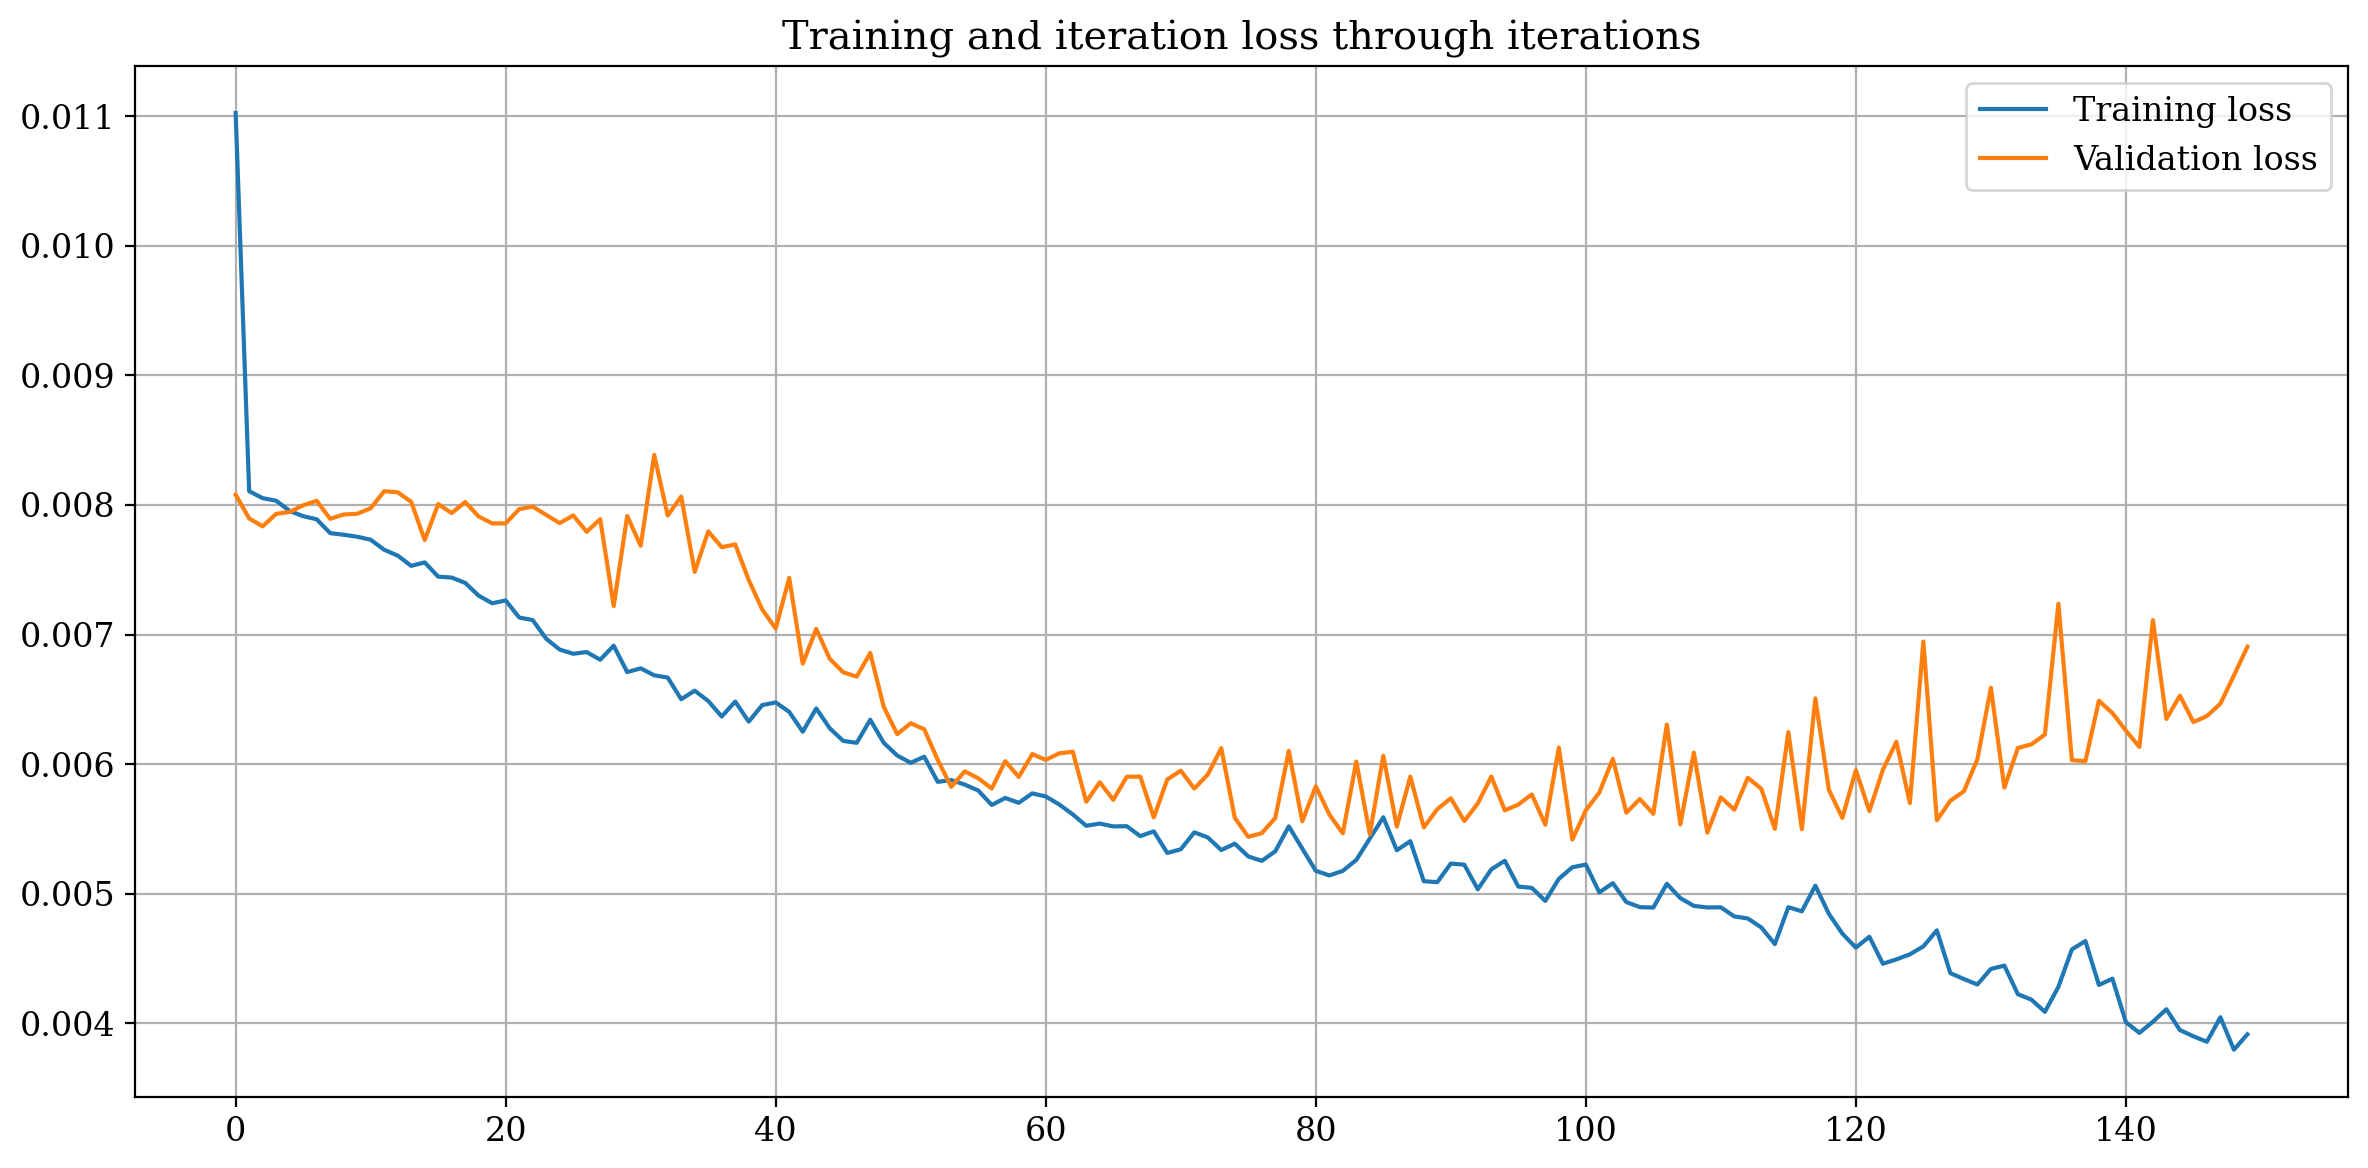

In [9]:
#plot the training and validation loss for each iteration for the LSTM model
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and iteration loss through iterations')
plt.grid(True)
plt.tight_layout()
plt.show()

In [10]:
#determine the best model according to the validation loss
min_val_loss = min(history.history['val_loss'])
min_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
print(f"Min validation loss of {min_val_loss} reached at epoch {min_val_loss_epoch}")

Minimum validation loss of 0.005417324136942625 reached at epoch 100


In [9]:
#load the model
model = load_model('checkpoints_LSTM_daily/model_epoch_100.h5')

In [10]:
#predict and calculate test RMSE
pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

2/2 [==============================] - 1s 172ms/step
Score (RMSE): 0.0701032186523979


In [11]:
#upload test predictions to the database
pred = scaler.inverse_transform(pred)
data = [(float(element), i+1) for i, element in enumerate(pred)]
query = "UPDATE rq3_test_predictions_daily SET lstm_nn = %s WHERE id = %s"
cursor.executemany(query, data)
db_connection.commit()

### Hourly data

In [15]:
query = '''
SELECT
    DATE_FORMAT(u.date_time, '%Y-%m-%d %H:00:00') as hour, 
    COUNT(*) as count,
    MAX(t.boxing_day) as boxing_day,
    MAX(t.boxing_day_obs) as boxing_day_obs,
    MAX(t.christmas_day) as christmas_day,
    MAX(t.christmas_day_obs) as christmas_day_obs,
    MAX(t.good_friday) as good_friday,
    MAX(t.may_day) as may_day,
    MAX(t.new_years_day) as new_years_day,
    MAX(t.new_years_day_obs) as new_years_day_obs,
    MAX(t.platinum_jubilee) as platinum_jubilee,
    MAX(t.spring_bank_holiday) as spring_bank_holiday,
    MAX(t.state_funeral) as state_funeral,
    MAX(t.outlier) as outlier
FROM use_of_force u
LEFT JOIN rq3_add_variables t 
  ON DATE_FORMAT(u.date_time, '%Y-%m-%d 00:00:00') = t.date
WHERE u.date_time > '2019-01-01 00:00:00' AND u.PrimaryConduct > 0
GROUP BY DATE_FORMAT(u.date_time, '%Y-%m-%d %H:00:00');
'''
time_series_daily = pd.read_sql(query, db_connection)

time_series_daily['hour'] = pd.to_datetime(time_series_daily['hour'])
time_series_daily.set_index('hour', inplace=True)
time_series_daily = time_series_daily.resample('H').sum()
time_series_daily = time_series_daily.reset_index()

scaler = MinMaxScaler()
time_series_daily['count'] = scaler.fit_transform(time_series_daily[['count']])

time_series_daily['hour'] = pd.to_datetime(time_series_daily['hour'])
time_series_daily = time_series_daily.set_index('hour')  
df = time_series_daily[['count', 'boxing_day', 'boxing_day_obs', 'christmas_day',
       'christmas_day_obs', 'good_friday', 'may_day', 'new_years_day',
       'new_years_day_obs', 'platinum_jubilee', 'spring_bank_holiday',
       'state_funeral', 'outlier']].values

C:\Users\Nikita\AppData\Local\Temp/ipykernel_16808/1564691695.py:23: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  time_series_daily = pd.read_sql(query, db_connection)


In [16]:
sequence_size = 30*24
x, y = to_sequences(sequence_size, df)

train_test_split_index = len(x) - 24*7
x_train = x[:train_test_split_index]
y_train = y[:train_test_split_index]
x_test = x[train_test_split_index:]
y_test = y[train_test_split_index:]
print("Shape of training set: {}".format(x_train.shape))
print("Shape of test set: {}".format(x_test.shape))

Shape of training set: (27574, 720, 13)
Shape of test set: (168, 720, 13)


In [ ]:
model = Sequential()
model.add(InputLayer((x_test.shape[1], x_test.shape[2]))) 
model.add(LSTM(500, activation='tanh', return_sequences=True))
model.add(Dropout(0.1))
model.add(LSTM(500, activation='tanh'))
model.add(Dense(128, 'relu'))
model.add(Dense(64, 'relu'))
model.add(Dense(1, 'linear'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 500)          1028000   
                                                                 
 dropout (Dropout)           (None, 720, 500)          0         
                                                                 
 lstm_1 (LSTM)               (None, 500)               2002000   
                                                                 
 dense (Dense)               (None, 128)               64128     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 3,102,449
Trainable params: 3,102,449
Non-

In [ ]:
os.makedirs("checkpoints_LSTM_agg_holidays_hourly", exist_ok=True)
model_checkpoint = ModelCheckpoint('checkpoints_LSTM_agg_holidays_hourly/model_epoch_{epoch:02d}.h5', 
                                   monitor='val_loss', verbose=1, save_best_only=False, mode='min')
early_stop = keras.callbacks.EarlyStopping(patience=50, restore_best_weights=True)
model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001))
history = model.fit(x_train, y_train, validation_split=0.1, shuffle=False, epochs=100, 
                     batch_size=128, callbacks=[model_checkpoint, early_stop])

Epoch 1/100
194/194 [==============================] - ETA: 0s - loss: 0.0069
Epoch 1: saving model to checkpoints_LSTM_agg_holidays_hourly\model_epoch_01.h5
194/194 [==============================] - 82s 401ms/step - loss: 0.0069 - val_loss: 0.0043
Epoch 2/100
194/194 [==============================] - ETA: 0s - loss: 0.0048
Epoch 2: saving model to checkpoints_LSTM_agg_holidays_hourly\model_epoch_02.h5
194/194 [==============================] - 78s 402ms/step - loss: 0.0048 - val_loss: 0.0042
Epoch 3/100
194/194 [==============================] - ETA: 0s - loss: 0.0047
Epoch 3: saving model to checkpoints_LSTM_agg_holidays_hourly\model_epoch_03.h5
194/194 [==============================] - 78s 403ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 4/100
194/194 [==============================] - ETA: 0s - loss: 0.0046
Epoch 4: saving model to checkpoints_LSTM_agg_holidays_hourly\model_epoch_04.h5
194/194 [==============================] - 78s 404ms/step - loss: 0.0046 - val_loss: 0.0041


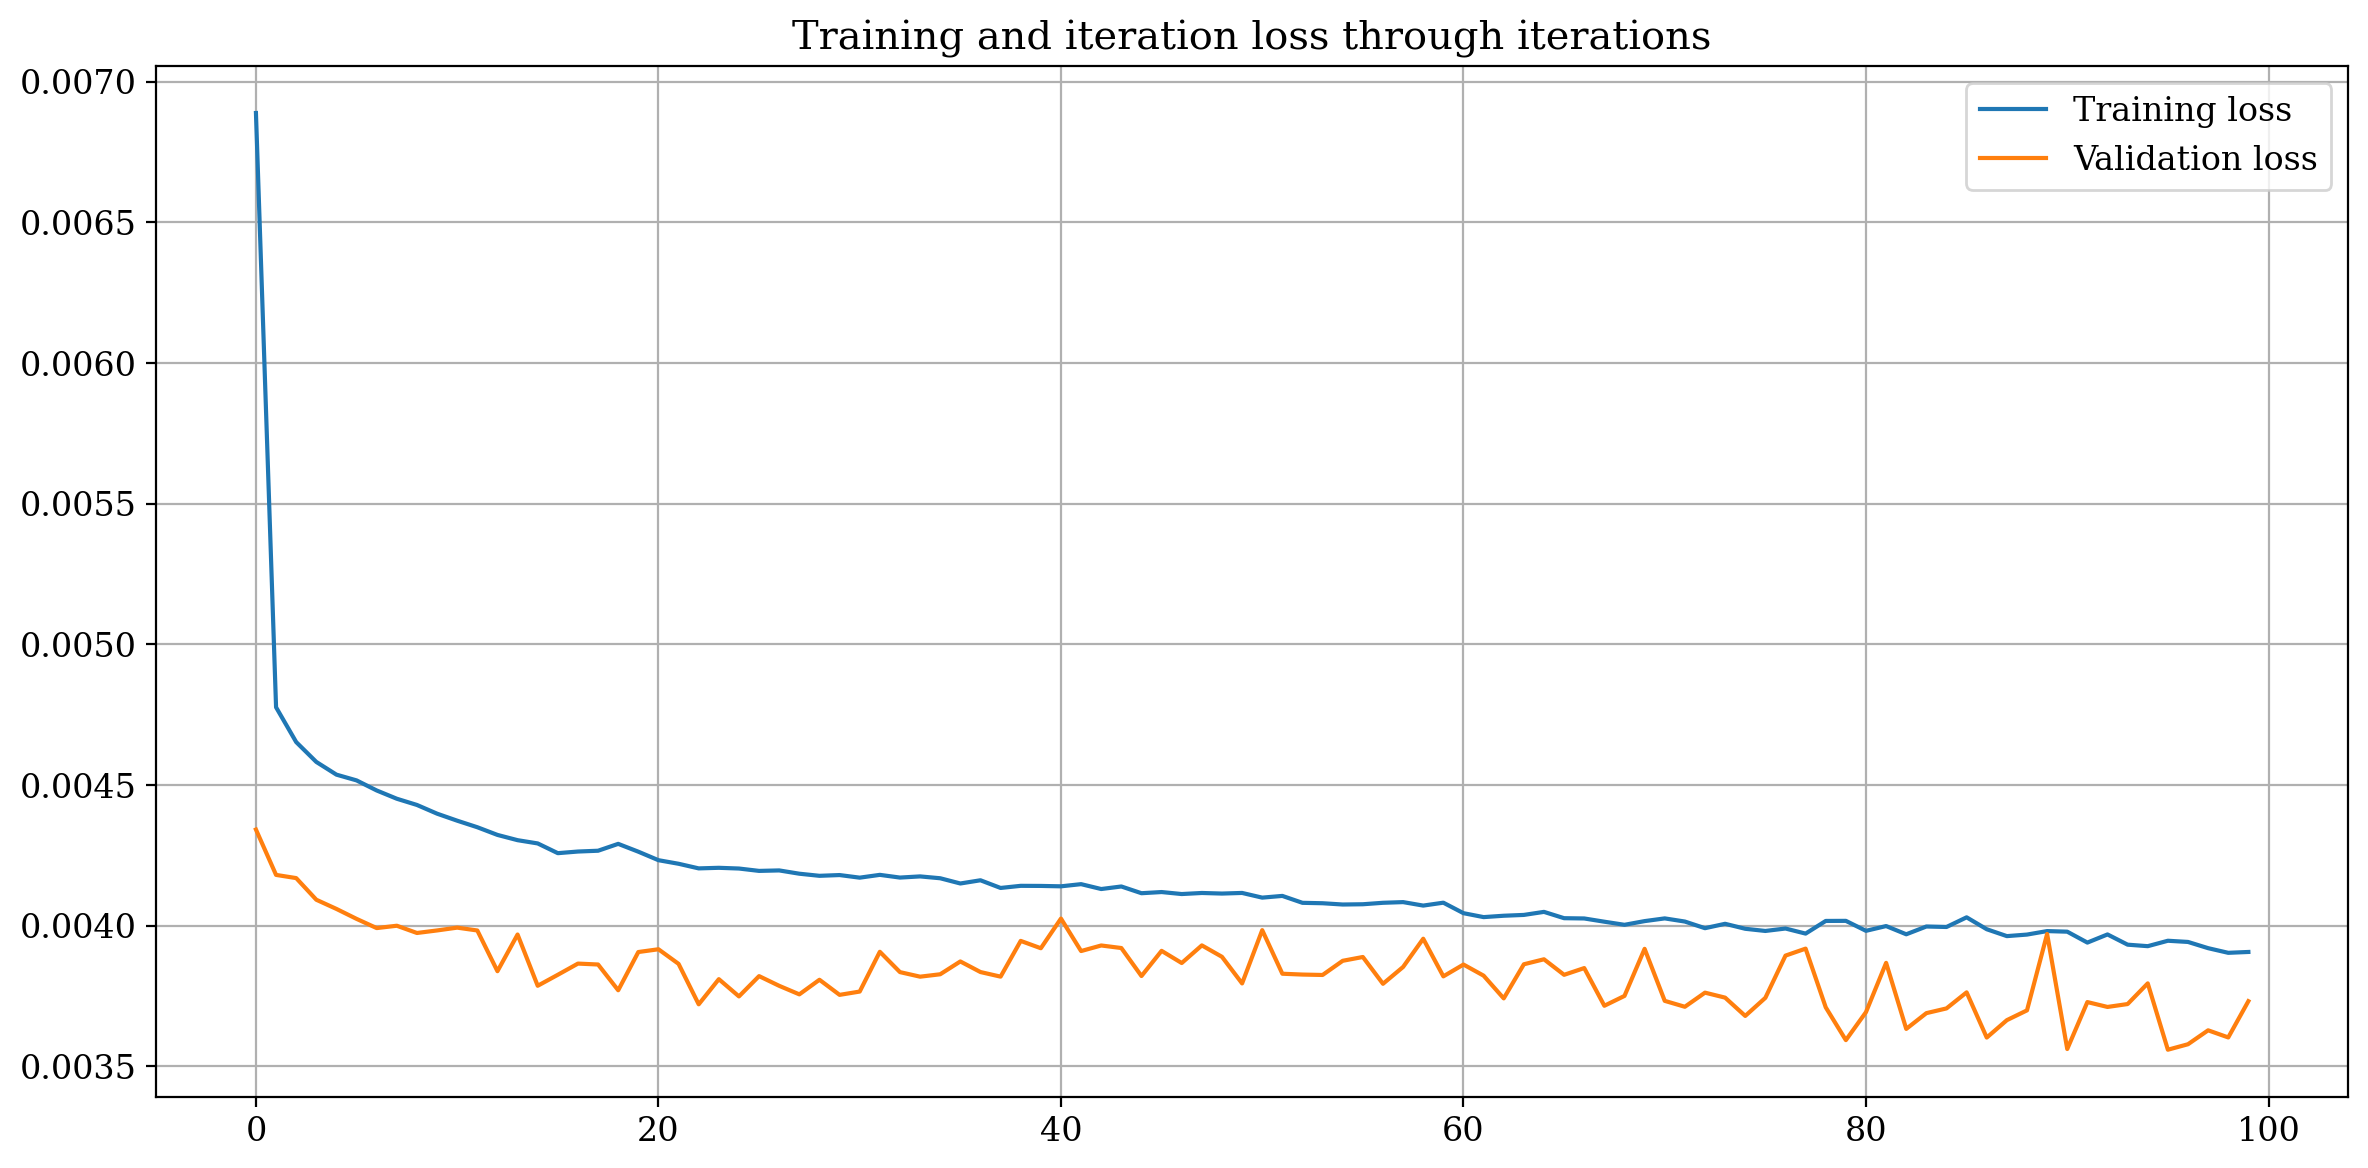

In [ ]:
plt.figure(figsize=(12, 6), dpi=200)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()
plt.title('Training and iteration loss through iterations')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
min_val_loss = min(history.history['val_loss'])
min_val_loss_epoch = np.argmin(history.history['val_loss']) + 1
print(f"Min validation loss of {min_val_loss} reached at epoch {min_val_loss_epoch}")

Minimum validation loss of 0.003559340722858906 reached at epoch 96


In [17]:
model = load_model('checkpoints_LSTM_hourly/model_epoch_96.h5')

pred = model.predict(x_test)
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

6/6 [==============================] - 23s 4s/step
Score (RMSE): 0.059457443273147136


In [18]:
#upload test predictions to the database
pred = scaler.inverse_transform(pred)
data = [(float(element), i+1) for i, element in enumerate(pred)]
query = "UPDATE rq3_test_predictions_hourly SET lstm_nn = %s WHERE id = %s"
cursor.executemany(query, data)
db_connection.commit()